# Part 5 - Logistic Regression

**By Aziz Presswala**

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pickle
import os
import math
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import find
from tqdm import tqdm
from prettytable import PrettyTable

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

### Splitting the Dataset into Train & Test

In [2]:
# Using the CleanedText column saved in final.sqlite db
con = sqlite3.connect('final.sqlite')
filtered_data = pd.read_sql_query("SELECT * FROM Reviews", con)
filtered_data.shape

(364171, 12)

In [3]:
# replacing all the 'positive' values of the Score attribute with 1
filtered_data['Score']=filtered_data['Score'].replace('positive',1)

In [4]:
# replacing all the 'neagtive' values of the Score attribute with 0
filtered_data['Score']=filtered_data['Score'].replace('negative',0)

In [5]:
#randomly selecting 100k points from the dataset
df=filtered_data.sample(100000)

In [6]:
#sort the dataset by timestamp
df = df.sort_values('Time')
#splitting the dataset into train(70%) & test(30%)
train_data = df[0:70000]
test_data = df[70000:100000]

## Featurization

### BAG OF WORDS

In [7]:
#applying fit transform on train datasset
count_vect = CountVectorizer(min_df=10)
x_train_bow = count_vect.fit_transform(train_data['CleanedText'].values)
x_train_bow.shape

(70000, 7220)

In [8]:
#applying transform on test dataset
x_test_bow = count_vect.transform(test_data['CleanedText'].values)
x_test_bow.shape

(30000, 7220)

In [9]:
y_train_bow = train_data['Score']
y_test_bow = test_data['Score']

### TF-IDF

In [10]:
#applying fit transform on train datasset
tf_idf_vect = TfidfVectorizer(min_df=10)
x_train_tfidf = tf_idf_vect.fit_transform(train_data['CleanedText'].values)
x_train_tfidf.shape

(70000, 7205)

In [11]:
#applying transform on test dataset
x_test_tfidf = tf_idf_vect.transform(test_data['CleanedText'].values)
x_test_tfidf.shape

(30000, 7205)

In [12]:
y_train_tfidf = train_data['Score']
y_test_tfidf = test_data['Score']

### Avg. Word2Vec

In [59]:
#training Word2Vec Model for train dataset
i=0
list_of_sent=[]
for sent in train_data['CleanedText'].values:
    list_of_sent.append(sent.split())

In [60]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [61]:
X = w2v_model[w2v_model.wv.vocab]

In [62]:
#computing Avg Word2Vec for train dataset
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [02:58<00:00, 393.20it/s]


70000
50


In [63]:
x_train_w2v = np.array(sent_vectors)
y_train_w2v = train_data['Score']
x_train_w2v.shape

(70000, 50)

In [64]:
#training Word2Vec Model for test dataset
i=0
list_of_sent1=[]
for sent in test_data['CleanedText'].values:
    list_of_sent1.append(sent.split())

In [65]:
#computing Avg Word2Vec for test dataset
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent1): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:14<00:00, 405.07it/s]


30000
50


In [66]:
x_test_w2v = np.array(sent_vectors)
y_test_w2v = test_data['Score']
x_test_w2v.shape

(30000, 50)

### TFIDF - Word2Vec

In [75]:
# training model for training data
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(train_data['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [76]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [03:03<00:00, 380.69it/s]


In [77]:
x_train_tfw2v = np.array(tfidf_sent_vectors)
y_train_tfw2v = train_data['Score']
x_train_tfw2v.shape

(70000, 50)

In [79]:
# training model for test dataset
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(test_data['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [80]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:28<00:00, 338.80it/s]


In [81]:
x_test_tfw2v = np.array(tfidf_sent_vectors)
y_test_tfw2v = test_data['Score']
x_test_tfw2v.shape

(30000, 50)

## Applying Logistic Regression

### Logistic Regression on BOW

### Applying Logistic Regression with L1 regularization on BOW

In [10]:
# initializing Logistic Regression model with L1 regularisation
lr = LogisticRegression(penalty='l1')

# C values we need to try on classifier
C_values = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}

# using GridSearchCV to find the optimal value of C
# using roc_auc as the scoring parameter & applying 10 fold CV
gscv = GridSearchCV(lr,param_grid,scoring='roc_auc',cv=10,return_train_score=True)

gscv.fit(x_train_bow,y_train_bow)

print("Best C Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best C Value:  {'C': 0.5}
Best ROC AUC Score: 0.92936


In [11]:
# determining optimal C
optimal_C = gscv.best_params_['C']

#training the model using the optimal C
lrf = LogisticRegression(penalty='l1',C=optimal_C)
lrf.fit(x_train_bow,y_train_bow)

#predicting the class label using test data 
y_pred = lrf.predict_proba(x_test_bow)[:,1]

#determining the Test roc_auc_score for optimal C
auc_score = roc_auc_score(y_test_bow, y_pred)
print('\n**** Test roc_auc_score for C = %f is %f ****' % (optimal_C,auc_score))


**** Test roc_auc_score for C = 0.500000 is 0.932319 ****


**AUC vs C plot**

[6.907755278982137, 6.214608098422191, 4.605170185988092, 3.912023005428146, 2.302585092994046, 1.6094379124341003, 0.0, -0.6931471805599453, -2.3025850929940455, -2.995732273553991, -4.605170185988091, -5.298317366548036, -6.907755278982137, -7.600902459542082, -9.210340371976182]


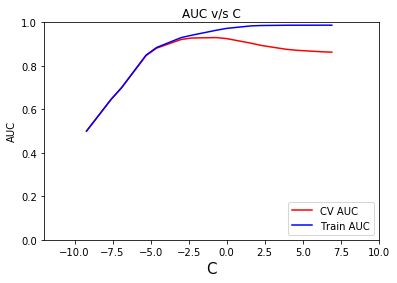

In [16]:
# plotting AUC vs C on Train & Validation dataset
log_alpha=[math.log(x) for x in C_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel(r"C",fontsize=15)
plt.ylabel('AUC')
plt.title(r'AUC v/s C')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

[[ 3197  1957]
 [  762 24084]]


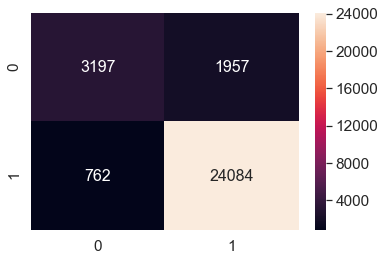

In [17]:
#plotting confusion matrix as heatmap
cm = confusion_matrix(y_test_bow, y_pred)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

**ROC Curve**

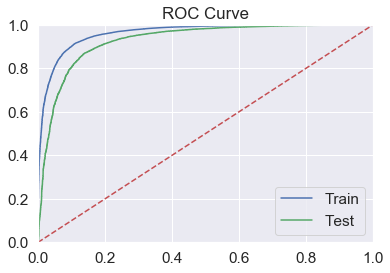

In [18]:
# Plotting roc curve on Train Data
pred_train = lrf.predict_proba(x_train_bow)[:,1]
fpr, tpr, threshold = roc_curve(y_train_bow, pred_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
pred_test = lrf.predict_proba(x_test_bow)[:,1]
fpr, tpr, threshold = roc_curve(y_test_bow, pred_test)
plt.plot(fpr, tpr, 'g', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

#### [1.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [19]:
#Calculating sparsity on weight vector using optimal C value and L1 regularization
lrf = LogisticRegression(C=optimal_C, penalty= 'l1')
lrf.fit(x_train_bow,y_train_bow)
pred = lrf.predict(x_test_bow)
print("Size of the weight vector:",len(lrf.coef_[0]))
print("No. of Non Zero weights:",np.count_nonzero(lrf.coef_))
print('Sparsity =', (len(lrf.coef_[0])-np.count_nonzero(lrf.coef_)))

Size of the weight vector: 7205
No. of Non Zero weights: 2608
Sparsity = 4597


### Applying Logistic Regression with L2 regularization on BOW

In [41]:
# initializing Logistic Regression model with L2 regularisation
lr = LogisticRegression(penalty='l2',max_iter=1000)

# using GridSearchCV to find the optimal value of C
# using roc_auc as the scoring parameter & applying 1 fold CV
gscv = GridSearchCV(lr,param_grid,scoring='roc_auc',cv=2,return_train_score=True)

gscv.fit(x_train_bow,y_train_bow)

print("Best C Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best C Value:  {'C': 0.1}
Best ROC AUC Score: 0.87426


In [42]:
# determining optimal C
optimal_C = gscv.best_params_['C']

#training the model using the optimal C
lrf = LogisticRegression(penalty='l2',C=optimal_C)
lrf.fit(x_train_bow,y_train_bow)

#predicting the class label using test data 
y_pred = lrf.predict(x_test_bow)

#determining the Test roc_auc_score for optimal C
auc_score = roc_auc_score(y_test_bow, y_pred)
print('\n**** Test roc_auc_score for C = %f is %f ****' % (optimal_C,auc_score))


**** Test roc_auc_score for C = 0.100000 is 0.774518 ****


**AUC vs C plot**

[6.907755278982137, 6.214608098422191, 4.605170185988092, 3.912023005428146, 2.302585092994046, 1.6094379124341003, 0.0, -0.6931471805599453, -2.3025850929940455, -2.995732273553991, -4.605170185988091, -5.298317366548036, -6.907755278982137, -7.600902459542082, -9.210340371976182]


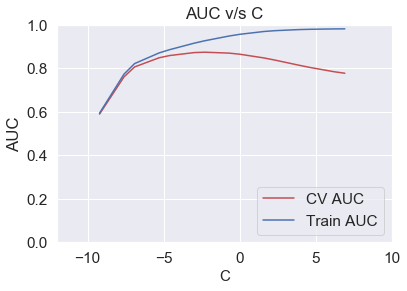

In [43]:
# plotting AUC vs C on Train & Validation dataset
log_alpha=[math.log(x) for x in C_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel(r"C",fontsize=15)
plt.ylabel('AUC')
plt.title(r'AUC v/s C')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

[[ 3197  1957]
 [  762 24084]]


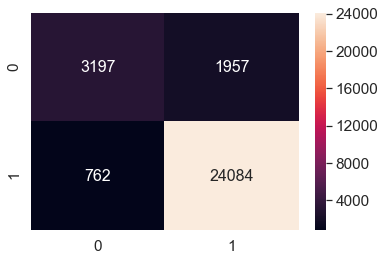

In [44]:
#plotting confusion matrix as heatmap
cm = confusion_matrix(y_test_bow, pred)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Performing pertubation test (multicollinearity check) on BOW

In [20]:
# weight vector before adding noise
weight1 = lrf.coef_[0]
print(weight1[:50])

[ 0.          0.          0.          0.19961079  0.          0.
  0.          0.         -0.93373078  0.27533887  0.          0.
  0.          0.          0.          0.          0.         -0.27312584
  0.          0.         -0.57000398  0.          0.12731565  0.13471111
  0.          0.          0.          0.          0.          1.28418421
  0.          1.00466245  0.          0.         -0.28736664  0.
  0.79777289  0.         -0.11235233 -0.13702158  0.          0.
  0.16282287  0.         -0.25887163  0.54482719  0.          0.
  0.          0.08212421]


In [21]:
X_train_t = x_train_bow
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))

#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]

In [22]:
#Training the model on the noise added dataset
lr = LogisticRegression(C= optimal_C, penalty= 'l1')
lr.fit(X_train_t,y_train_bow)
y_pred = lr.predict(x_test_bow)
print("Non Zero weights:",np.count_nonzero(lr.coef_))

Non Zero weights: 2423


In [23]:
# weight vector after adding noise
weight2 = lr.coef_[0]
print(weight2[:50])

[ 0.          0.          0.          0.27306786  0.          0.
  0.          0.         -0.56250695  0.37033967  0.          0.
  0.          0.          0.15584686  0.          0.         -0.16526306
  0.          0.         -0.98455298  0.64297284  0.          0.
  0.          0.          0.          0.          0.          0.24996729
  0.          0.28208293  0.          0.          0.          0.
  0.          0.         -0.11049378  0.          0.          0.
  0.         -0.78722114 -0.32519839  0.35393533  0.          0.
  0.         -0.02090544]


In [24]:
#adding a small value to both the weight vectors
val=10**-6
weight1+=val
weight2+=val

In [25]:
# calculating the percentage change 
percent_change = abs((weight1 - weight2)/weight1) * 100
# no. of vectors that have a percentage change of more than 30%
print(percent_change[np.where(percent_change>30)].size)

2475


**2475 features of 7205 have a percentage change greater than 30%. Hence the features are multicollinear.** 

### Feature Importance on BOW

#### Top 10 important features of positive & negative class

In [42]:
#getting the feature names
feature_names = count_vect.get_feature_names()

#getting their corresponding log probabilities
coefs_with_fns = sorted(zip(lrf.coef_[0], feature_names))

#selecting the top 10 negative & positive features 
top = zip(coefs_with_fns[:10], coefs_with_fns[:-(10 + 1):-1])
print("\t\t\tNegative\t\t\t\tPositive")
print("__________________________________________________________________________________________________")
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

			Negative				Positive
__________________________________________________________________________________________________
	-2.4672	worst          				2.3582	skeptic        
	-1.9923	aw             				2.1666	happier        
	-1.9653	terribl        				2.0430	hook           
	-1.9143	threw          				1.5808	yummi          
	-1.9120	tasteless      				1.5784	uniqu          
	-1.8529	yuck           				1.5019	excel          
	-1.6849	cancel         				1.5008	amaz           
	-1.6487	horribl        				1.4916	awesom         
	-1.6437	disappoint     				1.4478	delici         
	-1.5628	bland          				1.4238	addict         


### Logistic Regression on TFIDF

### Applying Logistic Regression with L1 regularization on TFIDF

In [32]:
# initializing Logistic Regression model with L1 regularisation
lr = LogisticRegression(penalty='l1')

# using GridSearchCV to find the optimal value of C
# using roc_auc as the scoring parameter & applying 10 fold CV
gscv = GridSearchCV(lr,param_grid,scoring='roc_auc',cv=10,return_train_score=True)

gscv.fit(x_train_tfidf,y_train_tfidf)

print("Best C Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best C Value:  {'C': 1}
Best ROC AUC Score: 0.94246


In [33]:
# determining optimal C
optimal_C = gscv.best_params_['C']

#training the model using the optimal C
lrf = LogisticRegression(penalty='l1',C=optimal_C)
lrf.fit(x_train_tfidf,y_train_tfidf)

#predicting the class label using test data 
y_pred = lrf.predict(x_test_tfidf)

#determining the Test roc_auc_score for optimal C
auc_score = roc_auc_score(y_test_tfidf, y_pred)
print('\n**** Test roc_auc_score for C = %f is %f ****' % (optimal_C,auc_score))


**** Test roc_auc_score for C = 1.000000 is 0.793112 ****


**AUC vs C plot**

[6.907755278982137, 6.214608098422191, 4.605170185988092, 3.912023005428146, 2.302585092994046, 1.6094379124341003, 0.0, -0.6931471805599453, -2.3025850929940455, -2.995732273553991, -4.605170185988091, -5.298317366548036, -6.907755278982137, -7.600902459542082, -9.210340371976182]


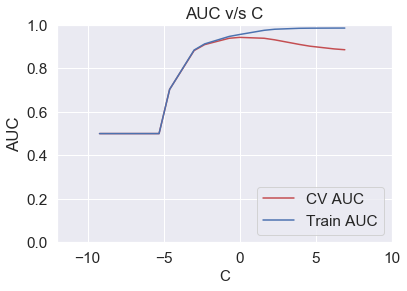

In [34]:
# plotting AUC vs C on Train & Validation dataset
log_alpha=[math.log(x) for x in C_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel(r"C",fontsize=15)
plt.ylabel('AUC')
plt.title(r'AUC v/s C')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

[[ 3197  1957]
 [  762 24084]]


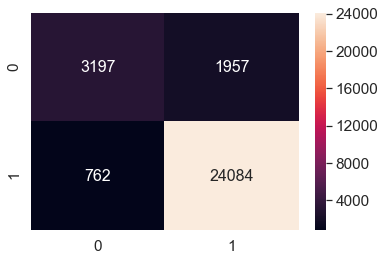

In [35]:
#plotting confusion matrix as heatmap
cm = confusion_matrix(y_test_tfidf, pred)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Applying Logistic Regression with L2 regularization on TFIDF

In [36]:
# initializing Logistic Regression model with L2 regularisation
lr = LogisticRegression(penalty='l2')

# using GridSearchCV to find the optimal value of C
# using roc_auc as the scoring parameter & applying 10 fold CV
gscv = GridSearchCV(lr,param_grid,scoring='roc_auc',cv=10,return_train_score=True)

gscv.fit(x_train_tfidf,y_train_tfidf)

print("Best C Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best C Value:  {'C': 1}
Best ROC AUC Score: 0.94428


In [37]:
# determining optimal C
optimal_C = gscv.best_params_['C']

#training the model using the optimal C
lrf = LogisticRegression(penalty='l2',C=optimal_C)
lrf.fit(x_train_tfidf,y_train_tfidf)

#predicting the class label using test data 
y_pred = lrf.predict(x_test_tfidf)

#determining the Test roc_auc_score for optimal C
auc_score = roc_auc_score(y_test_tfidf, y_pred)
print('\n**** Test roc_auc_score for C = %f is %f ****' % (optimal_C,auc_score))


**** Test roc_auc_score for C = 1.000000 is 0.776427 ****


**AUC vs C plot**

[6.907755278982137, 6.214608098422191, 4.605170185988092, 3.912023005428146, 2.302585092994046, 1.6094379124341003, 0.0, -0.6931471805599453, -2.3025850929940455, -2.995732273553991, -4.605170185988091, -5.298317366548036, -6.907755278982137, -7.600902459542082, -9.210340371976182]


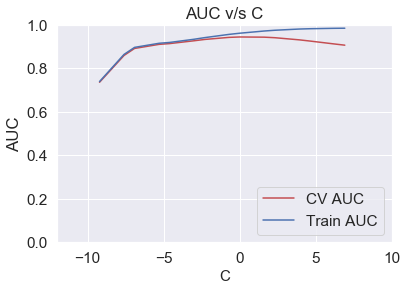

In [38]:
# plotting AUC vs C on Train & Validation dataset
log_alpha=[math.log(x) for x in C_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel(r"C",fontsize=15)
plt.ylabel('AUC')
plt.title(r'AUC v/s C')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

[[ 3197  1957]
 [  762 24084]]


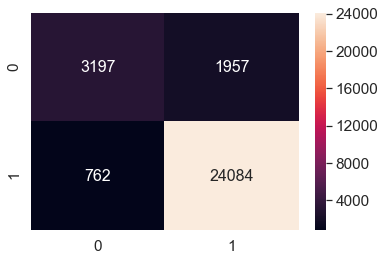

In [39]:
#plotting confusion matrix as heatmap
cm = confusion_matrix(y_test_tfidf, pred)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Feature Importance on TFIDF

#### Top 10 important features of positive & negative class

In [58]:
#getting the feature names
feature_names = tf_idf_vect.get_feature_names()

#getting their corresponding log probabilities
coefs_with_fns = sorted(zip(lrf.coef_[0], feature_names))

#selecting the top 10 negative & positive features 
top = zip(coefs_with_fns[:10], coefs_with_fns[:-(10 + 1):-1])
print("\t\t\tNegative\t\t\t\tPositive")
print("__________________________________________________________________________________________________")
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

			Negative				Positive
__________________________________________________________________________________________________
	-7.6603	disappoint     				10.5891	great          
	-6.9781	worst          				8.0863	best           
	-6.2206	terribl        				7.7130	love           
	-5.9027	aw             				7.1773	delici         
	-5.8746	horribl        				6.7693	perfect        
	-5.1977	return         				6.1566	excel          
	-5.1381	threw          				5.6250	amaz           
	-4.7565	unfortun       				5.4546	good           
	-4.7096	bland          				5.1198	nice           
	-4.6534	stale          				5.0755	favorit        


### Logistic Regression on AVG W2V

### Applying Logistic Regression with L1 regularization on AVG W2V

In [67]:
# initializing Logistic Regression model with L1 regularisation
lr = LogisticRegression(penalty='l1')

# using GridSearchCV to find the optimal value of C
# using roc_auc as the scoring parameter & applying 10 fold CV
gscv = GridSearchCV(lr,param_grid,scoring='roc_auc',cv=10,return_train_score=True)

gscv.fit(x_train_w2v,y_train_w2v)

print("Best C Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best C Value:  {'C': 0.5}
Best ROC AUC Score: 0.90405


In [68]:
# determining optimal C
optimal_C = gscv.best_params_['C']

#training the model using the optimal C
lrf = LogisticRegression(penalty='l1',C=optimal_C)
lrf.fit(x_train_w2v,y_train_w2v)

#predicting the class label using test data 
y_pred = lrf.predict(x_test_w2v)

#determining the Test roc_auc_score for optimal C
auc_score = roc_auc_score(y_test_w2v, y_pred)
print('\n**** Test roc_auc_score for C = %f is %f ****' % (optimal_C,auc_score))


**** Test roc_auc_score for C = 0.500000 is 0.719229 ****


**AUC vs C plot**

[6.907755278982137, 6.214608098422191, 4.605170185988092, 3.912023005428146, 2.302585092994046, 1.6094379124341003, 0.0, -0.6931471805599453, -2.3025850929940455, -2.995732273553991, -4.605170185988091, -5.298317366548036, -6.907755278982137, -7.600902459542082, -9.210340371976182]


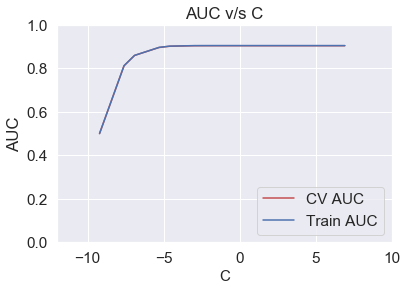

In [69]:
# plotting AUC vs C on Train & Validation dataset
log_alpha=[math.log(x) for x in C_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel(r"C",fontsize=15)
plt.ylabel('AUC')
plt.title(r'AUC v/s C')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

[[ 3201  1964]
 [  801 24034]]


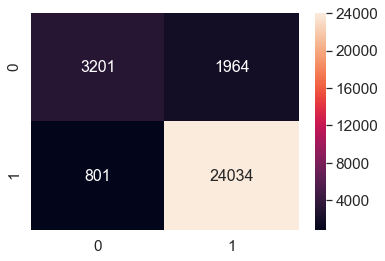

In [70]:
#plotting confusion matrix as heatmap
cm = confusion_matrix(y_test_w2v, pred)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Applying Logistic Regression with L2 regularization on AVG W2V

In [71]:
# initializing Logistic Regression model with L2 regularisation
lr = LogisticRegression(penalty='l2')

# using GridSearchCV to find the optimal value of C
# using roc_auc as the scoring parameter & applying 10 fold CV
gscv = GridSearchCV(lr,param_grid,scoring='roc_auc',cv=10,return_train_score=True)

gscv.fit(x_train_w2v,y_train_w2v)

print("Best C Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best C Value:  {'C': 0.05}
Best ROC AUC Score: 0.90407


In [72]:
# determining optimal C
optimal_C = gscv.best_params_['C']

#training the model using the optimal C
lrf = LogisticRegression(penalty='l2',C=optimal_C)
lrf.fit(x_train_w2v,y_train_w2v)

#predicting the class label using test data 
y_pred = lrf.predict(x_test_w2v)

#determining the Test roc_auc_score for optimal C
auc_score = roc_auc_score(y_test_w2v, y_pred)
print('\n**** Test roc_auc_score for C = %f is %f ****' % (optimal_C,auc_score))


**** Test roc_auc_score for C = 0.050000 is 0.715671 ****


**AUC vs C plot**

[6.907755278982137, 6.214608098422191, 4.605170185988092, 3.912023005428146, 2.302585092994046, 1.6094379124341003, 0.0, -0.6931471805599453, -2.3025850929940455, -2.995732273553991, -4.605170185988091, -5.298317366548036, -6.907755278982137, -7.600902459542082, -9.210340371976182]


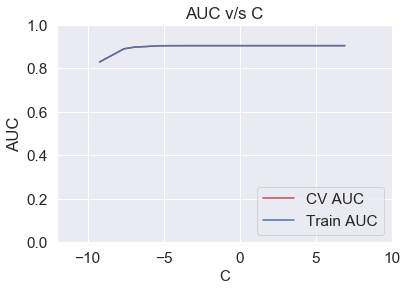

In [73]:
# plotting AUC vs C on Train & Validation dataset
log_alpha=[math.log(x) for x in C_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel(r"C",fontsize=15)
plt.ylabel('AUC')
plt.title(r'AUC v/s C')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

[[ 3201  1964]
 [  801 24034]]


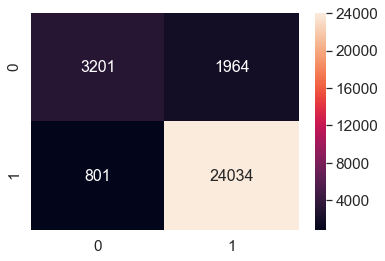

In [74]:
#plotting confusion matrix as heatmap
cm = confusion_matrix(y_test_w2v, pred)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Logistic Regression on TFIDF W2V

### Applying Logistic Regression with L1 regularization on TFIDF W2V

In [82]:
# initializing Logistic Regression model with L1 regularisation
lr = LogisticRegression(penalty='l1')

# using GridSearchCV to find the optimal value of C
# using roc_auc as the scoring parameter & applying 10 fold CV
gscv = GridSearchCV(lr,param_grid,scoring='roc_auc',cv=10,return_train_score=True)

gscv.fit(x_train_tfw2v,y_train_tfw2v)

print("Best C Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best C Value:  {'C': 0.1}
Best ROC AUC Score: 0.87825


In [83]:
# determining optimal C
optimal_C = gscv.best_params_['C']

#training the model using the optimal C
lrf = LogisticRegression(penalty='l1',C=optimal_C)
lrf.fit(x_train_tfw2v,y_train_tfw2v)

#predicting the class label using test data 
y_pred = lrf.predict(x_test_tfw2v)

#determining the Test roc_auc_score for optimal C
auc_score = roc_auc_score(y_test_tfw2v, y_pred)
print('\n**** Test roc_auc_score for C = %f is %f ****' % (optimal_C,auc_score))


**** Test roc_auc_score for C = 0.100000 is 0.666148 ****


**AUC vs C plot**

[6.907755278982137, 6.214608098422191, 4.605170185988092, 3.912023005428146, 2.302585092994046, 1.6094379124341003, 0.0, -0.6931471805599453, -2.3025850929940455, -2.995732273553991, -4.605170185988091, -5.298317366548036, -6.907755278982137, -7.600902459542082, -9.210340371976182]


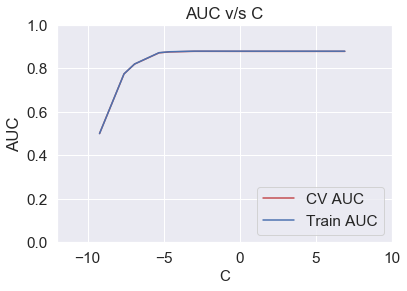

In [84]:
# plotting AUC vs C on Train & Validation dataset
log_alpha=[math.log(x) for x in C_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel(r"C",fontsize=15)
plt.ylabel('AUC')
plt.title(r'AUC v/s C')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

[[ 3201  1964]
 [  801 24034]]


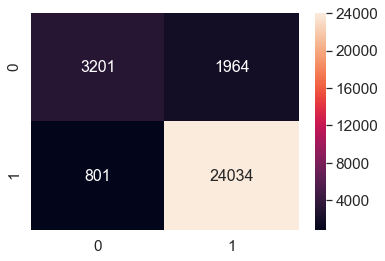

In [85]:
#plotting confusion matrix as heatmap
cm = confusion_matrix(y_test_tfw2v, pred)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Applying Logistic Regression with L2 regularization on TFIDF W2V

In [86]:
# initializing Logistic Regression model with L2 regularisation
lr = LogisticRegression(penalty='l2')

# using GridSearchCV to find the optimal value of C
# using roc_auc as the scoring parameter & applying 10 fold CV
gscv = GridSearchCV(lr,param_grid,scoring='roc_auc',cv=10,return_train_score=True)

gscv.fit(x_train_tfw2v,y_train_tfw2v)

print("Best C Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best C Value:  {'C': 0.05}
Best ROC AUC Score: 0.87827


In [87]:
# determining optimal C
optimal_C = gscv.best_params_['C']

#training the model using the optimal C
lrf = LogisticRegression(penalty='l2',C=optimal_C)
lrf.fit(x_train_tfw2v,y_train_tfw2v)

#predicting the class label using test data 
y_pred = lrf.predict(x_test_tfw2v)

#determining the Test roc_auc_score for optimal C
auc_score = roc_auc_score(y_test_tfw2v, y_pred)
print('\n**** Test roc_auc_score for C = %f is %f ****' % (optimal_C,auc_score))


**** Test roc_auc_score for C = 0.050000 is 0.664893 ****


**AUC vs C plot**

[6.907755278982137, 6.214608098422191, 4.605170185988092, 3.912023005428146, 2.302585092994046, 1.6094379124341003, 0.0, -0.6931471805599453, -2.3025850929940455, -2.995732273553991, -4.605170185988091, -5.298317366548036, -6.907755278982137, -7.600902459542082, -9.210340371976182]


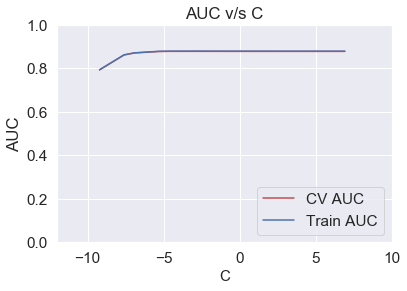

In [88]:
# plotting AUC vs C on Train & Validation dataset
log_alpha=[math.log(x) for x in C_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel(r"C",fontsize=15)
plt.ylabel('AUC')
plt.title(r'AUC v/s C')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

[[ 3201  1964]
 [  801 24034]]


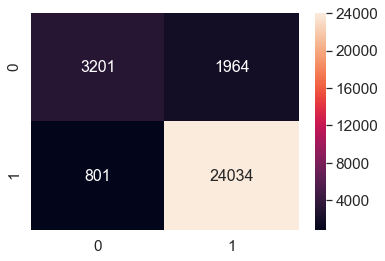

In [89]:
#plotting confusion matrix as heatmap
cm = confusion_matrix(y_test_tfw2v, pred)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Conclusion

In [45]:
# Summarizing the observations
x=PrettyTable()
x.field_names = ['Vectorizer','Penalty','C','AUC']
x.add_row(['BOW','L1','0.50','0.794813'])
x.add_row(['BOW','L2','0.10','0.774518'])
x.add_row(['Tfidf','L1','1.00','0.793112'])
x.add_row(['Tfidf','L2','1.00','0.776427'])
x.add_row(['Avg. Word2Vec','L1','0.50','0.719229'])
x.add_row(['Avg. Word2Vec','L2','0.05','0.715671'])
x.add_row(['Tfidf W2V','L1','0.10','0.666148'])
x.add_row(['Tfidf W2V','L2','0.05','0.664893'])
print(x)

+---------------+---------+------+----------+
|   Vectorizer  | Penalty |  C   |   AUC    |
+---------------+---------+------+----------+
|      BOW      |    L1   | 0.50 | 0.794813 |
|      BOW      |    L2   | 0.10 | 0.774518 |
|     Tfidf     |    L1   | 1.00 | 0.793112 |
|     Tfidf     |    L2   | 1.00 | 0.776427 |
| Avg. Word2Vec |    L1   | 0.50 | 0.719229 |
| Avg. Word2Vec |    L2   | 0.05 | 0.715671 |
|   Tfidf W2V   |    L1   | 0.10 | 0.666148 |
|   Tfidf W2V   |    L2   | 0.05 | 0.664893 |
+---------------+---------+------+----------+


Conclusions:-
1. From the above table, the performance of Logistic Regression using different vectorizers can be summed as follows -
   BoW > TFIDF > Avg. Word2Vec > TFIDF-W2V, with performance of BoW being the greatest in terms of AUC scores.
2. As proved in theory that L1 regularization increases sparsity, same was observed when BoW was implemented with L1    regularization.
3. Also, it was proved that the features were multicollinear when Pertubation Test was performed.